In [1]:
from datetime import datetime, timezone, timedelta

from crlx import SIKULIAQ
import bottleneck
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from requests.compat import urljoin
import warnings
from typing import Union

import xarray as xr
import pickle

In [4]:
skq = SIKULIAQ(verbose=True)

In [80]:
first = 13
last = 25

for i in range(first,last+1):
    bdt = datetime(2024,8,i)
    edt = bdt + timedelta(days=1)
    apollo = skq.get_wet_lab_apollo(bdt, edt)
    ldeo = skq.get_wet_lab_ldeo(bdt, edt)
    apollo_re = apollo
    apollo_re = apollo_re.sortby('time')
    apollo_re = apollo_re.resample(time='20min').mean()

    ldeo_re = ldeo
    ldeo_re = ldeo_re.sortby('time')
    ldeo_re = ldeo_re.resample(time='20min',skipna = True).mean()
    
    # check that they are the same length
    delta_sw = ldeo_re.sea_water_pco2-apollo_re.sea_water_pco2
    delta_at = ldeo_re.air_pco2-apollo_re.air_pco2
    
    # open previous days of data and add
    if i == first:
        with open('apollo_full.pickle', 'wb') as f:
            pickle.dump(apollo_re, f, pickle.HIGHEST_PROTOCOL)
        
        with open('ldeo_full.pickle', 'wb') as f:
            pickle.dump(ldeo_re, f, pickle.HIGHEST_PROTOCOL)
        
    else:
        with open('apollo_full.pickle', 'rb') as f:
            apollo_full = pickle.load(f)
        
        with open('ldeo_full.pickle', 'rb') as f:
            ldeo_full = pickle.load(f)
        
        apollo_full_update = xr.concat([apollo_full,apollo_re],dim="time")
        ldeo_full_update = xr.concat([ldeo_full,ldeo_re],dim="time")
        
        with open('apollo_full.pickle', 'wb') as f:
            pickle.dump(apollo_full_update, f, pickle.HIGHEST_PROTOCOL)
        
        with open('ldeo_full.pickle', 'wb') as f:
            pickle.dump(ldeo_full_update, f, pickle.HIGHEST_PROTOCOL)

In [81]:
with open('apollo_full.pickle', 'rb') as f:
    apollo_all = pickle.load(f)
        
with open('ldeo_full.pickle', 'rb') as f:
    ldeo_all = pickle.load(f)

In [82]:
apollo_all

<xarray.Dataset> Size: 194kB
Dimensions:                            (time: 866)
Coordinates:
  * time                               (time) datetime64[ns] 7kB 2024-08-13 ....
Data variables: (12/27)
    air_fco2                           (time) float64 7kB 404.7 nan ... nan nan
    air_pco2                           (time) float64 7kB 406.3 nan ... nan nan
    air_temperature                    (time) float64 7kB 7.35 nan ... nan nan
    air_water_vapor_pressure           (time) float64 7kB 0.00982 nan ... nan
    apollo_sbe45_pracsal               (time) float64 7kB 29.2 28.53 ... 30.43
    apollo_sbe45_temp                  (time) float64 7kB 7.824 9.438 ... 7.001
    ...                                 ...
    purge_interval                     (time) float64 7kB 120.0 nan ... nan
    sea_surface_temperature            (time) float64 7kB 7.038 7.026 ... 6.403
    sea_water_fco2                     (time) float64 7kB 467.2 488.7 ... 379.5
    sea_water_pco2                     (time) float64 7kB 606.6 636.9 ... 478.9
    sea_water_practical_salinity       (time) float64 7kB 29.2 28.53 ... 30.43
    xco2_corr                          (time) float64 7kB 464.4 499.7 ... 385.4
Attributes:
    sensor_id:      pcotwo002101
    sensor_name:    pCO2_Apollo
    sensor_class:   Flowthrough
    sensor_prefix:  pcotwo
    serial_number:  2101-OSU
    description:    The Apollo ASP3 provides sea surface and atmospheric pCO2...
    location_text:  Wet Lab
    vendor:         Apollo Scitech
    model:          Apollo SciTech AS-P3 combined pCO2 analyser and underway ...
    system:         FLOWTHROUGH
    location:       WET-LAB

In [83]:
ldeo_all

<xarray.Dataset> Size: 124kB
Dimensions:                            (time: 862)
Coordinates:
  * time                               (time) datetime64[ns] 7kB 2024-08-13 ....
Data variables: (12/17)
    air_temperature                    (time) float64 7kB nan nan ... nan 6.52
    barometric_pressure                (time) float64 7kB 1.005e+03 ... 1.01e+03
    sea_surface_temperature            (time) float64 7kB 7.049 7.004 ... 6.421
    sea_water_practical_salinity       (time) float64 7kB 29.27 29.25 ... 30.46
    xco2_corr                          (time) float64 7kB 451.1 454.1 ... 416.0
    air_water_vapor_pressure           (time) float64 7kB nan nan ... 0.00935
    ...                                 ...
    equilibrator_pressure              (time) float64 7kB 1.006e+03 ... nan
    equilibrator_temperature_sbe38     (time) float64 7kB 7.584 7.434 ... nan
    equilibrator_water_vapor_pressure  (time) float64 7kB 0.01013 ... nan
    equilibrator_pco2                  (time) float64 7kB 443.4 446.4 ... nan
    sea_water_pco2                     (time) float64 7kB 573.0 575.7 ... nan
    sea_water_fco2                     (time) float64 7kB 441.7 444.6 ... nan
Attributes:
    sensor_id:      pcotwo000338
    sensor_name:    pCO2_LDEO
    sensor_class:   Flowthrough
    sensor_prefix:  pcotwo
    serial_number:  LI-6251 IRG1-338
    description:    LDEO pCO2 Seawater Sensor; a system for the underway cont...
    location_text:  Wet Lab
    vendor:         Lamont-Doherty Earth Observatory
    model:          Lamont-Doherty Earth Observatory pCO2 underway system
    system:         FLOWTHROUGH
    location:       WET-LAB

In [98]:
delta_sw = ldeo_all.sea_water_pco2-apollo_all.sea_water_pco2
delta_at = ldeo_all.air_pco2-apollo_all.air_pco2
time_delta = ldeo_all.time

delta_teq = ldeo_all.equilibrator_temperature_sbe38-apollo_all.apollo_sbe45_temp
delta_peq = ldeo_all.equilibrator_pressure-apollo_all.equilibrator_pressure
delta_cor = ldeo_all.xco2_corr-apollo_all.xco2_corr
delta_gas = ldeo_all.gas_flow_rate-apollo_all.gas_flow_rate

In [97]:
len(ldeo_all.time)

862

In [99]:
time_delta = time_delta.to_numpy()
delta_sw = delta_sw.to_numpy()
delta_at = delta_at.to_numpy()
delta_teq = delta_teq.to_numpy()
delta_peq = delta_peq.to_numpy()
delta_cor = delta_cor.to_numpy()
delta_gas = delta_gas.to_numpy()

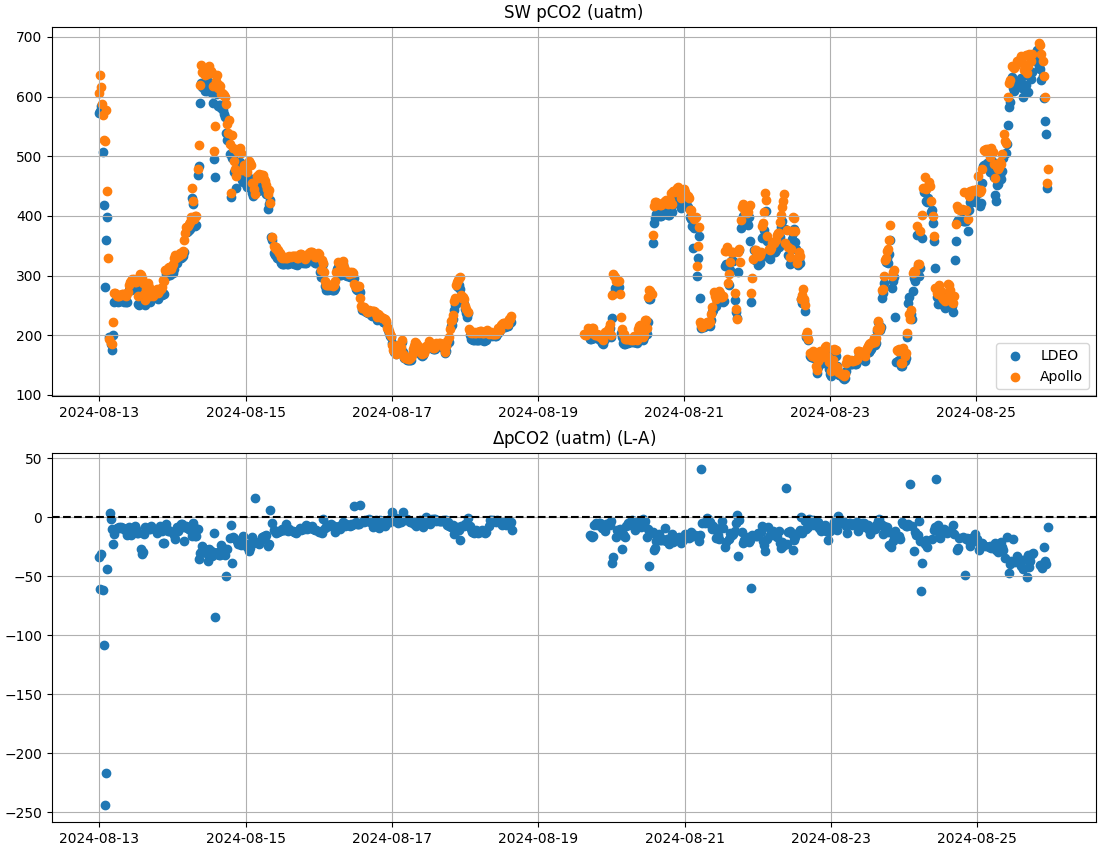

Mean difference =  -14.235566535379592 uatm
Mean difference (no outliers in beginning) =  -12.90134187888477 uatm
Mean difference (when pCO2 < 400) =  -10.83273318814082 uatm
Mean difference (when pCO2 < 300) =  -8.632964161275947 uatm
Mean difference (when pCO2 < 200) =  -6.4796513377174305 uatm


In [107]:
fig,ax = plt.subplots(2,1, figsize = (11,8.5), constrained_layout = True)
ax[0].scatter(ldeo_all.time,ldeo_all.sea_water_pco2,label="LDEO")
ax[0].scatter(apollo_all.time,apollo_all.sea_water_pco2,label="Apollo")
ax[0].legend()
ax[0].set_title('SW pCO2 (uatm)')
ax[0].grid()

ax[1].scatter(time_delta,delta_sw,label="Delta")
ax[1].axhline(0, color = 'black',linestyle = '--')
ax[1].set_title('$\Delta$pCO2 (uatm) (L-A)')
ax[1].grid()
plt.show()

print('Mean difference (LDEO-Apollo) = ',np.nanmean(delta_sw),'uatm')
print('Mean difference (LDEO-Apollo) (no outliers in beginning) = ',np.nanmean(delta_sw[delta_sw > -50]),'uatm')
print('Mean difference (LDEO-Apollo) (when pCO2 < 400) = ',np.nanmean(delta_sw[ldeo_all.sea_water_pco2 < 400]),'uatm')
print('Mean difference (LDEO-Apollo) (when pCO2 < 300) = ',np.nanmean(delta_sw[ldeo_all.sea_water_pco2 < 300]),'uatm')
print('Mean difference (LDEO-Apollo) (when pCO2 < 200) = ',np.nanmean(delta_sw[ldeo_all.sea_water_pco2 < 200]),'uatm')

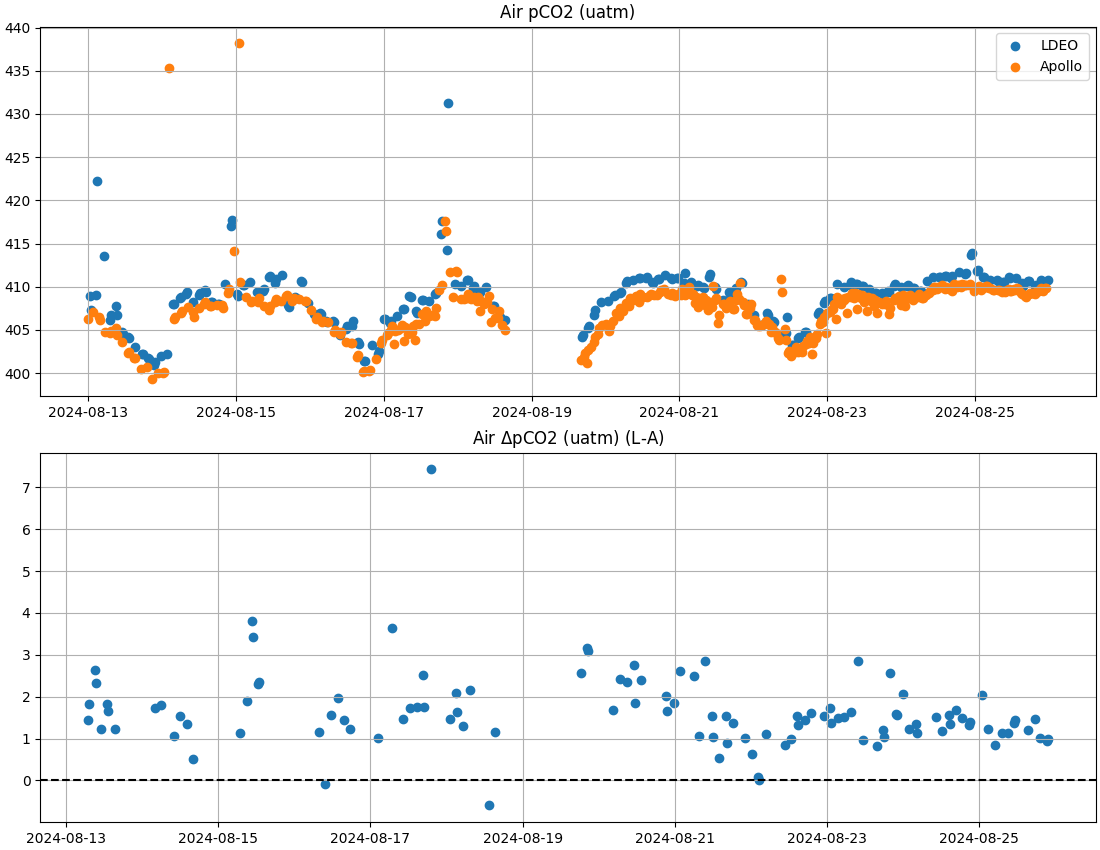

Mean difference =  1.6349864325140173 uatm


In [105]:
fig,ax = plt.subplots(2,1, figsize = (11,8.5), constrained_layout = True)
ax[0].scatter(ldeo_all.time,ldeo_all.air_pco2,label="LDEO")
ax[0].scatter(apollo_all.time,apollo_all.air_pco2,label="Apollo")
ax[0].legend()
ax[0].set_title('Air pCO2 (uatm)')
ax[0].grid()

ax[1].scatter(time_delta,delta_at,label="Delta")
ax[1].axhline(0, color = 'black',linestyle = '--')
ax[1].set_title('Air $\Delta$pCO2 (uatm) (L-A)')
ax[1].grid()
plt.show()

print('Mean difference (LDEO-Apollo) = ',np.nanmean(delta_at),'uatm')

Mean difference Teq (LDEO-Apollo) =  -0.31452081654900327 C
Mean difference Peq (LDEO-Apollo) =  -0.26478993449231697 atm
Mean difference gfr (LDEO-Apollo) =  -103.89705217399337 mL/min
Mean difference xcorr (LDEO-Apollo) =  -20.122698206163555 ppm


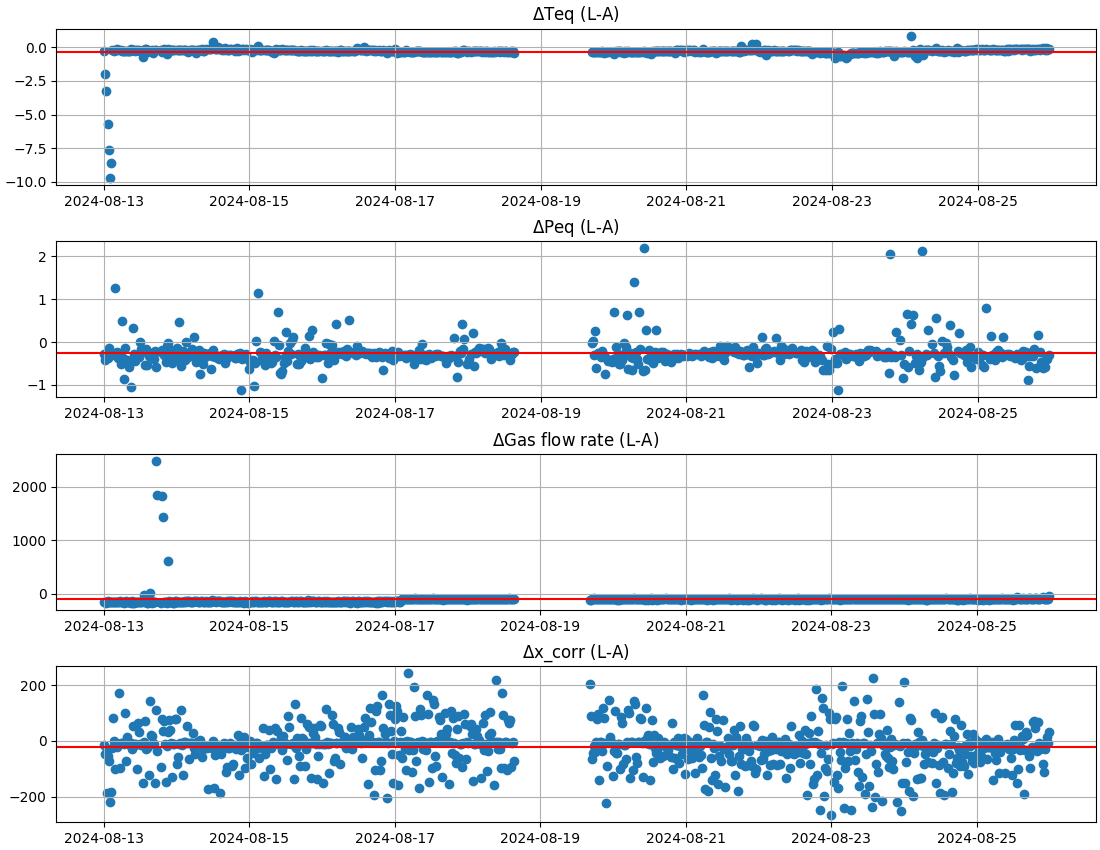

In [115]:
%matplotlib widget

fig, ax = plt.subplots(4, 1, figsize=(11, 8.5), constrained_layout=True)
ax[0].scatter(time_delta, delta_teq)
ax[0].axhline(np.nanmean(delta_teq), color = 'red', label='Mean')
ax[0].set_title('$\Delta$Teq (L-A)')
ax[0].grid()
print('Mean difference Teq (LDEO-Apollo) = ',np.nanmean(delta_teq),'C')

ax[1].scatter(time_delta, delta_peq)
ax[1].axhline(np.nanmean(delta_peq), color = 'red', label='Mean')
ax[1].set_title('$\Delta$Peq (L-A)')
ax[1].grid()
print('Mean difference Peq (LDEO-Apollo) = ',np.nanmean(delta_peq),'atm')

ax[2].scatter(time_delta, delta_gas)
ax[2].axhline(np.nanmean(delta_gas), color = 'red', label='Mean')
ax[2].set_title('$\Delta$Gas flow rate (L-A)')
ax[2].grid()
print('Mean difference gfr (LDEO-Apollo) = ',np.nanmean(delta_gas),'mL/min')

ax[3].scatter(time_delta, delta_cor)
ax[3].axhline(np.nanmean(delta_cor), color = 'red', label='Mean')
ax[3].set_title('$\Delta$x_corr (L-A)')
ax[3].grid()
print('Mean difference xcorr (LDEO-Apollo) = ',np.nanmean(delta_cor),'ppm')

plt.show()